In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
from pathlib import Path
from pixell import enmap,utils
from astropy.io import fits
from pixell import enplot
def eshow(x,**kwargs): enplot.show(enplot.plot(x,**kwargs))

In [3]:
config = yaml.load(open('config.yaml'))
data_dir = Path(config['data_dir'])

In [4]:
from bs4 import BeautifulSoup
import pandas as pd 
import datetime
import tqdm

In [5]:
soup = BeautifulSoup(open(data_dir / 'index.html'), 'html.parser')

In [6]:
td_list = soup.find_all('td')
html_data = []
TT_data = []

for td in tqdm.tqdm(td_list):
    contents = str(td.contents[0]).split(' ') # get tag contents
    _, src, _, az, _, el, _, idstr, _, date, time  = \
        [c for c in contents if c != ''] # strip empty strings and parse
    # clean up strings
    src = (src.split('\"')[-2]).replace('_0.png', '')
    az = float(az)
    el = float(el)
    time = time[:-3] # get rid of some extra characters
    datetime = pd.Timestamp(date + ' ' + time)
    html_data.append([src, az, el, idstr, datetime])
    temp_im = fits.getdata(str(data_dir / (src + '.fits')), 0)
    TT_data.append(temp_im[0].copy())
    del temp_im

meta = pd.DataFrame(html_data, columns=['src', 'az', 'el', 'id', 'time'] )
meta['time_delta'] = (meta['time'] - meta['time'].min())  / np.timedelta64(1,'D')
meta[['h','m','s']] = pd.DataFrame([(x.hour, x.minute, x.second) for x in meta['time']])
meta['float_hours'] = meta['h'] + meta['m'] / 60 + meta['s'] / 3600

100%|██████████| 2127/2127 [00:05<00:00, 424.82it/s]


Text(0, 0.5, 'time of day [h]')

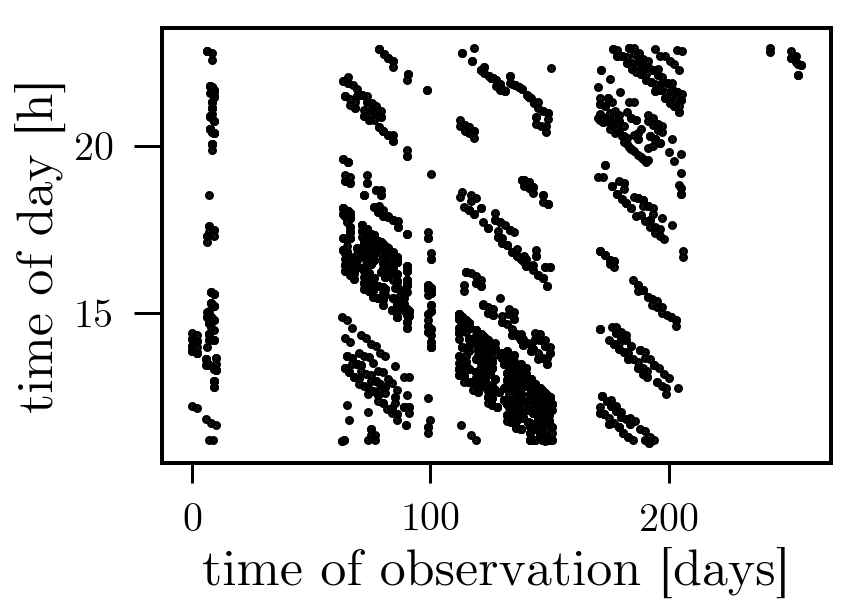

In [7]:
plt.plot( meta['time_delta'], meta['float_hours'], 'k.' )
plt.xlabel('time of observation [days]')
plt.ylabel('time of day [h]')

In [8]:
store = pd.HDFStore('store.h5')
store['meta'] = meta

In [9]:
stacked_images = np.stack(TT_data, axis=-1)
np.save("beam_images.npy", stacked_images)

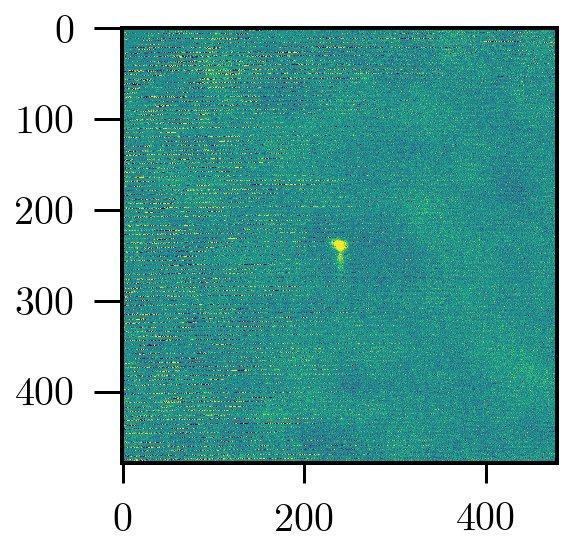

In [10]:
plt.imshow(stacked_images[:,:,1000], vmin = -5000, vmax=5000)